# Some history

## Pen & paper xercises 

### Timescales of stellar evolution

There are three main timescales in which stars evolve. These are the dynamical, thermal and nuclear timescales. Even without knowing the equations of stellar structure and evolution we can do some estimates on the value of these quantities. Compute these without a calculator! We only care about the order of magnitude of these timescales, which given all the approximations done is all we can do.

- Thermal timescale: One of the main early hypothesis to explain the energy source of the Sun was that it originated from its slow contraction into its own gravitational potential. In such a case, a rough estimate of the energy the Sun would have radiated through its life is given by:

    $$\Omega \sim \frac{GM_\odot^2}{R_\odot}$$

    Assuming that the luminosity of the Sun has always been its current one, $L_\odot$, compute the age of the Sun under the assumption

## Computational exercises

## Solution to pen & paper exercises

In [2]:
using DataFrames
using Plots
using CSV
using LaTeXStrings

In [312]:
function add1(x)
    return x+1
end

add1(1)

2

In [3]:
xvals = LinRange(-5.0,5.0,11)

11-element LinRange{Float64, Int64}:
 -5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0

In [315]:
add1.(xvals)

11-element Vector{Float64}:
 -4.0
 -3.0
 -2.0
 -1.0
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0

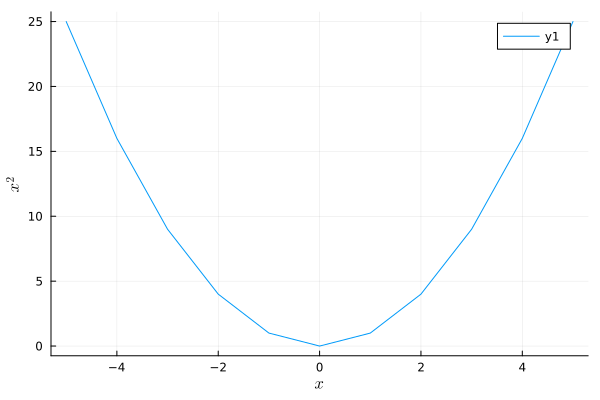

In [316]:
yvals = xvals.^2
plot(xlabel=L"$x$", ylabel=L"$x^2$")
plot!(xvals, yvals)

### Sources
- Gaia passband info: https://www.cosmos.esa.int/web/gaia/edr3-passbands
- Gaia archive: https://gea.esac.esa.int/archive/
- Sun Gaia magnitude: https://ui.adsabs.harvard.edu/abs/2018MNRAS.479L.102C/abstract
- Sun effective temperature (5772 K): Resolution B3 on recommended nominal conversion constants for selected solar and planetary properties Proposed by IAU Inter-Division A-G Working Group on Nominal Units for Stellar & Planetary Astronomy The XXIXth International Astronomical Union General Assembly, https://www.iau.org/static/resolutions/IAU2015_English.pdf
- Solar spectrum: https://www.nrel.gov/grid/solar-resource/spectra-astm-e490.html

In [300]:
h = 6.6261e-27      # Planck's constant, cm^2 g s^-1
c = 2.99792458e10   # speed of light cm s^-1
k_b = 1.3807e-16    # Boltzmann constant erg K-1
σ = 2*π^5*k_b^4/(15*h^3*c^2) # Stefan-Boltzmann constant
function spectral_radiance(λ,T) #λ in nm, T in Kelvin
    λ_cm = λ*1e-7
    return 2*h*c^2/λ_cm^5*(1/(exp(h*c/(λ_cm*k_b*T))-1))
end
function normalized_spectral_radiance(λ,T) #λ in nm, T in Kelvin
    peak_λ = h*c/(4.965*k_b*T)*1e7 #in nm
    return spectral_radiance(λ,T)/spectral_radiance(peak_λ,T)
end

normalized_spectral_radiance (generic function with 1 method)

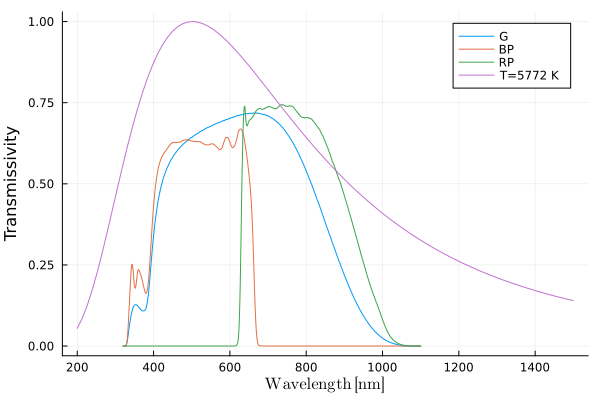

In [301]:
passbands = CSV.read("passband.dat", header=1, delim=" ", ignorerepeated=true, DataFrame)
plot(xlabel=L"$\mathrm{Wavelength\;[nm]}$", ylabel="Transmissivity")
plot!(passbands.lambda, passbands.G_pb, label="G")
plot!(passbands.lambda, passbands.BP_pb, label="BP")
plot!(passbands.lambda, passbands.RP_pb, label="RP")

xvals = LinRange(200.0,1500.0,100)
plot!(xvals, normalized_spectral_radiance.(xvals,5772), label="T=5772 K")

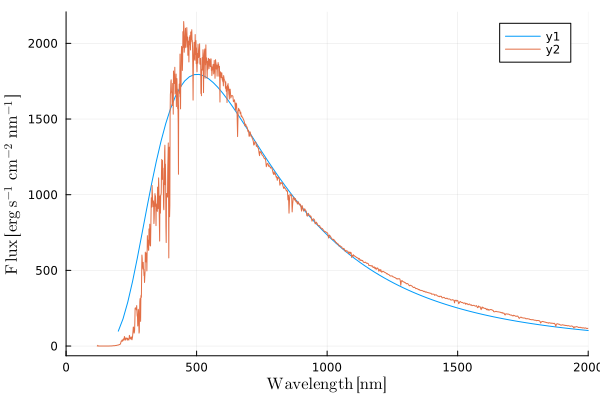

In [302]:
solar_spectrum = CSV.read("solar_spectrum.dat", header=1, delim=" ", ignorerepeated=true, DataFrame)
plot(xlabel=L"$\mathrm{Wavelength\;[nm]}$", ylabel=L"$\mathrm{Flux}\; [\mathrm{erg\;s^{-1}\;cm^{-2}\;nm^{-1}}]$", xlims=[0,2000])

xvals = LinRange(200.0,2000.0,100)
au = 1.5e13
Rsun = 7e10
plot!(xvals, pi*spectral_radiance.(xvals,5772)/1e7/(au/Rsun)^2)
plot!(solar_spectrum.lambda, solar_spectrum.flux)

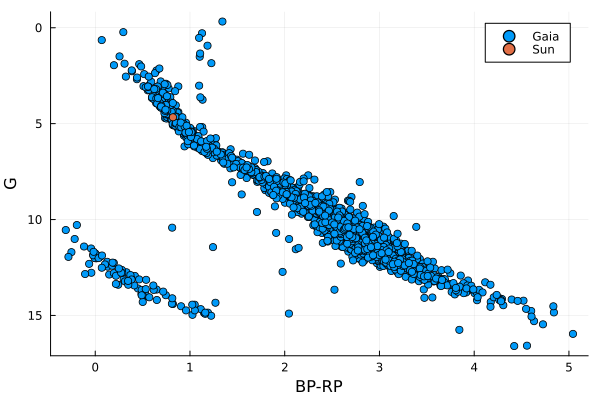

In [303]:
gaia_data = CSV.read("gaia_100pc_par_over_err_100.csv", header=1, DataFrame)

plot(xlabel="BP-RP", ylabel="G")
color = gaia_data.phot_bp_mean_mag - gaia_data.phot_rp_mean_mag
distance_pc = 1 ./ (1e-3.*gaia_data.parallax)
abs_G = gaia_data.phot_g_mean_mag .- 5 .* (log10.(distance_pc).-1)

G_sun = 4.67
BP_sun = G_sun+0.33
RP_sun = G_sun-0.49

scatter!(color, abs_G,label="Gaia")
scatter!([BP_sun-RP_sun],[G_sun], label="Sun")
yflip!(true)

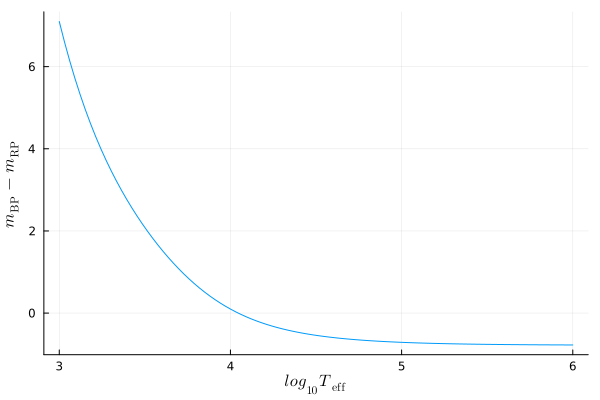

In [304]:
function flux_ratio_BP_RP(T)
    # Ignoring constant in the integration, relying on bins being equally spaced in lambda
    F_sun_BP = sum(passbands.BP_pb .* normalized_spectral_radiance.(passbands.lambda,T))
    F_sun_RP = sum(passbands.RP_pb .* normalized_spectral_radiance.(passbands.lambda,T))
    return F_sun_BP/F_sun_RP
end

diff_zero_point_BP_RP = 0.82+2.5*log10(flux_ratio_BP_RP(5772))

# sample 
log10_T_sample = LinRange(3.0,6.0,100)
BP_sub_RP = -2.5*log10.(flux_ratio_BP_RP.(10 .^ log10_T_sample)) .+ diff_zero_point_BP_RP

plot(xlabel=L"$log_{10} T_\mathrm{eff}$",ylabel=L"$m_\mathrm{BP}-m_\mathrm{RP}$")
plot!(log10_T_sample, BP_sub_RP,label="")

In [305]:
#bisection algorithm to get Teff from BP-RP
function log10_T_from_BP_sub_RP(BP_sub_RP)
    log10_T_min = 3.0
    log10_T_max = 6.0
    log10_T = 0.0
    while abs(log10_T_min-log10_T_max) > 0.001
        log10_T = 0.5*(log10_T_max + log10_T_min)
        BP_sub_RP_new = -2.5*log10.(flux_ratio_BP_RP(10^log10_T)) .+ diff_zero_point_BP_RP
        if BP_sub_RP_new > BP_sub_RP # T too low, update lower limit
            log10_T_min = log10_T
        else # otherwise, update upper limit
            log10_T_max = log10_T
        end
    end
    return log10_T
end

log10_T_from_BP_sub_RP (generic function with 1 method)

In [306]:
log10_T = log10_T_from_BP_sub_RP.(color);

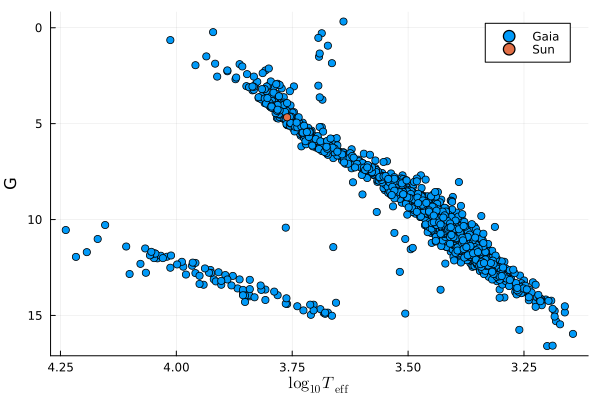

In [307]:
plot(xlabel=L"$\log_{10}T_\mathrm{eff}$", ylabel="G")

scatter!(log10_T, abs_G,label="Gaia")
scatter!([log10_T_from_BP_sub_RP(BP_sun-RP_sun)],[G_sun],label="Sun")
yflip!(true)
xflip!(true)

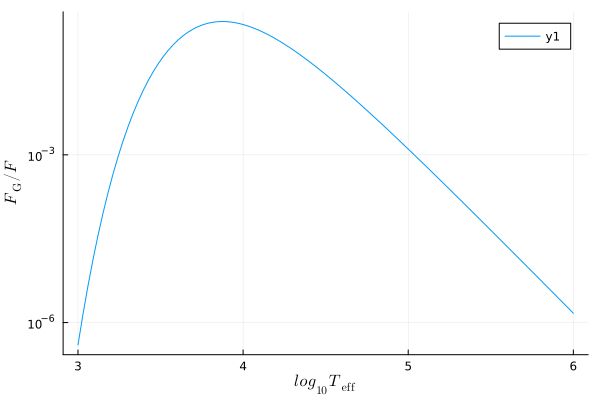

In [308]:
function flux_ratio_G_total(T)
    # Ignoring constant in the integration, relying on bins being equally spaced in lambda
    F_G = sum(passbands.BP_pb .* spectral_radiance.(passbands.lambda,T) .*1e-7)
    return π*F_G/(σ*T^4)
end

plot(xlabel=L"$log_{10} T_\mathrm{eff}$",ylabel=L"$F_\mathrm{G}/F$", yscale=:log)
plot!(log10_T_sample, flux_ratio_G_total.(10 .^ log10_T_sample))

In [309]:
#log10_L_div_Lsun = (G_sun .- abs_G)./(2.5) .-
#    log10.(flux_ratio_G_total.(10 .^ log10_T)) .+ log10.(flux_ratio_G_total.(5772));

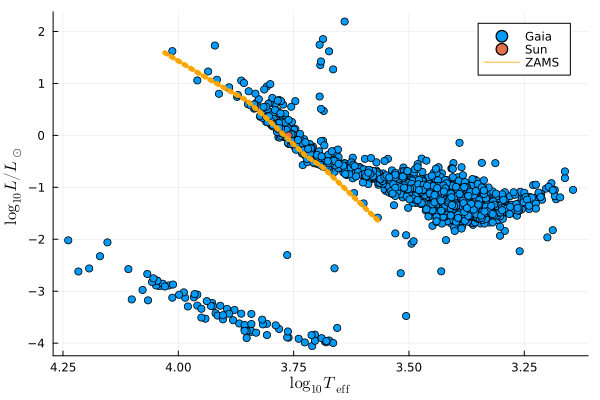

In [310]:
#plot(xlabel=L"$\log_{10}T_\mathrm{eff}$", ylabel=L"\log_{10}L/L_\odot")
#
## Predicted Zero-age main-sequence location for stars of masses (in Msun):
##     0.4, 0.8, 0.9, 1.0, 1.25, 1.5, 1.7, 2, 2.5
## All models except those with M=0.4 Msun are from Schaller et al. (1992):
## - https://ui.adsabs.harvard.edu/abs/1992A%26AS...96..269S/abstract
## Model at 0.4 Msun is from Charbonnel et al. (1999):
## - https://ui.adsabs.harvard.edu/abs/1999A%26AS..135..405C/abstract
#log10_T_geneva = [3.568, 3.687, 3.724, 3.751, 3.808, 3.852, 3.901, 3.958, 4.031]
#log10_L_geneva = [-1.63, -0.612, -0.394, -0.163, 0.325, 0.676, 0.916, 1.209, 1.600]
#
#scatter!(log10_T, log10_L_div_Lsun, label="Gaia")
##scatter!(log10_T, (G_sun .- abs_G)./(-2.5))
#scatter!([log10_T_from_BP_sub_RP(BP_sun-RP_sun)],[0], label="Sun")
#plot!(log10_T_geneva, log10_L_geneva, linewidth=5, linestyle= :dot, color="orange", label="ZAMS")
#xflip!(true)